# Import libs

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
from textblob import TextBlob as tb

from wordcloud import WordCloud, STOPWORDS
import numpy as np
from IPython.display import Image as im
from PIL import Image

from nltk import bigrams
import csv


import warnings
warnings.filterwarnings("ignore")


## Twitter API keys

In [3]:
consumer_key = "fzWj65UNcTLEXuyjxaVX5lrfE"
consumer_secret = "HekopZkSlYTtGG1b36pcQsafnw0FGJnINK36I6MsvrEaV64STg"
access_token = "963097913936228354-dS1jkEO5p9INxLjLl7V2HoqogYC53tf"
access_token_secret = "SCEyAeNgETWDhI1QEPSPj7VH2FUfUwkUyVvdzuZdGhpqZ"

In [4]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [5]:
def getTweets(searchQuery, fileName):
    maxTweets = 100000
    tweetsPerQry = 100
    sinceId = None
    max_id = -1
    tweetCount = 0
    with open(fileName, 'w') as csvfile:
        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, lang="en", count=tweetsPerQry)
                    else:
                        new_tweets = api.search(q=searchQuery, lang="en", count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, lang="en", count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = api.search(q=searchQuery, lang="en", count=tweetsPerQry,
                                                max_id=str(max_id - 1)
                                               )

                if not new_tweets:
                    print("No more tweets found")
                    break
                
                csvWriter = csv.writer(csvfile, lineterminator= '\n')
                for tweet in new_tweets:
                    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id
            except tw.TweepError as e:
                # Just exit if any error
                print("some error occurred : " + str(e))
                break

    print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fileName))

In [11]:
# not run if data already exists, otherwise will overwrite 
search_terms = [("#HSBC -filter:retweets", "HSBC2.csv"), ("#Allianz -filter:retweets", "Allianz2.csv"), ("#BNP -filter:retweets", "BNP2.csv")]

# please uncomment me to run
#for tweet, filename in search_terms:
#    getTweets(tweet, filename)


In [13]:
df_all_twt_hsbc = pd.read_csv('HSBC2.csv', header = None)
all_twt_hsbc = df_all_twt_hsbc[1].tolist()

df_all_twt_allianz = pd.read_csv('Allianz2.csv', header = None)
all_twt_allianz = df_all_twt_allianz[1].tolist()

df_all_twt_bnp = pd.read_csv('BNP2.csv', header = None)
all_twt_bnp = df_all_twt_bnp[1].tolist()

#Removing URLs

In [14]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())


In [15]:
all_twt_hsbc_no_url = pd.Series([remove_url(tweet) for tweet in all_twt_hsbc])
all_twt_allianz_no_url = pd.Series([remove_url(tweet) for tweet in all_twt_allianz])
all_twt_bnp_no_url = pd.Series([remove_url(tweet) for tweet in all_twt_bnp])

In [16]:
#Text Cleanup

In [17]:
all_twt_hsbc_no_url = all_twt_hsbc_no_url.unique()
all_twt_allianz_no_url = all_twt_allianz_no_url.unique()
all_twt_bnp_no_url = all_twt_bnp_no_url.unique()

In [18]:
# converting the list to lowercase

all_twt_hsbc_no_url = pd.Series([word.lower() for word in all_twt_hsbc_no_url])
all_twt_allianz_no_url = pd.Series([word.lower() for word in all_twt_allianz_no_url])
all_twt_bnp_no_url = pd.Series([word.lower() for word in all_twt_bnp_no_url])

In [19]:
# Spliting the words from one tweet to unique elements

all_twt_hsbc_split = [tweet.lower().split() for tweet in all_twt_hsbc_no_url]
all_twt_allianz_split = [tweet.lower().split() for tweet in all_twt_allianz_no_url]
all_twt_bnp_split = [tweet.lower().split() for tweet in all_twt_bnp_no_url]


In [20]:
all_twt_hsbc_words = list(itertools.chain(*all_twt_hsbc_split))
all_twt_allianz_words = list(itertools.chain(*all_twt_allianz_split))
all_twt_bnp_words = list(itertools.chain(*all_twt_bnp_split))


In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
hsbc_clean = [word for word in all_twt_hsbc_words if not word in stop_words]
allianz_clean = [word for word in all_twt_allianz_words if not word in stop_words]
bnp_clean = [word for word in all_twt_bnp_words if not word in stop_words]

In [23]:
hsbc_word_count = collections.Counter(hsbc_clean)
allianz_word_count = collections.Counter(allianz_clean)
bnp_word_count = collections.Counter(bnp_clean)


In [24]:
hsbc_df = pd.DataFrame(hsbc_word_count.most_common(20), columns=['words', 'count'])
allianz_df = pd.DataFrame(allianz_word_count.most_common(20), columns=['words', 'count'])
bnp_df = pd.DataFrame(bnp_word_count.most_common(20), columns=['words', 'count'])

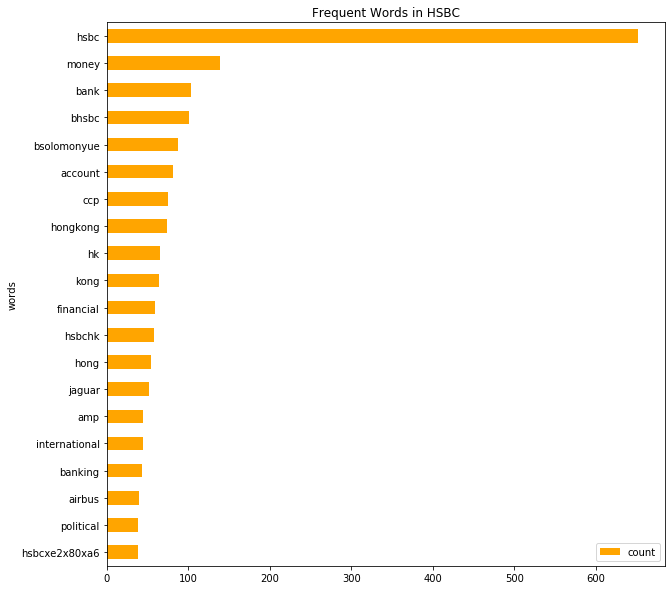

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
hsbc_df.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="orange")

ax.set_title("Frequent Words in HSBC")
plt.show()

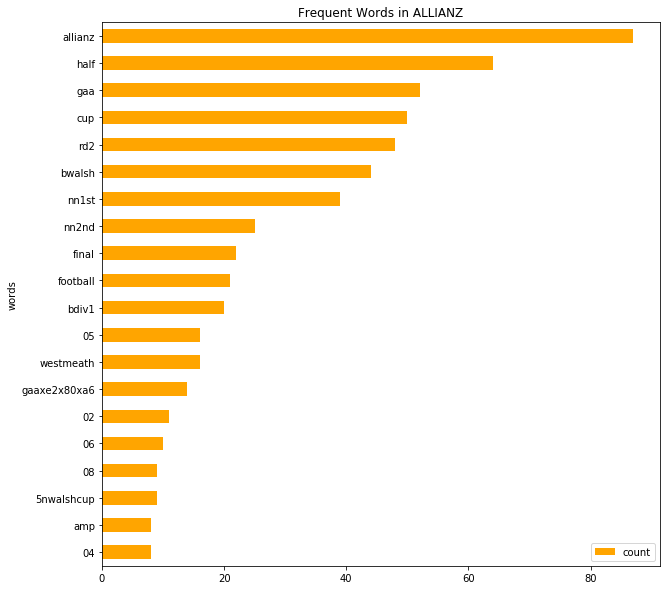

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
allianz_df.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="orange")

ax.set_title("Frequent Words in ALLIANZ")
plt.show()

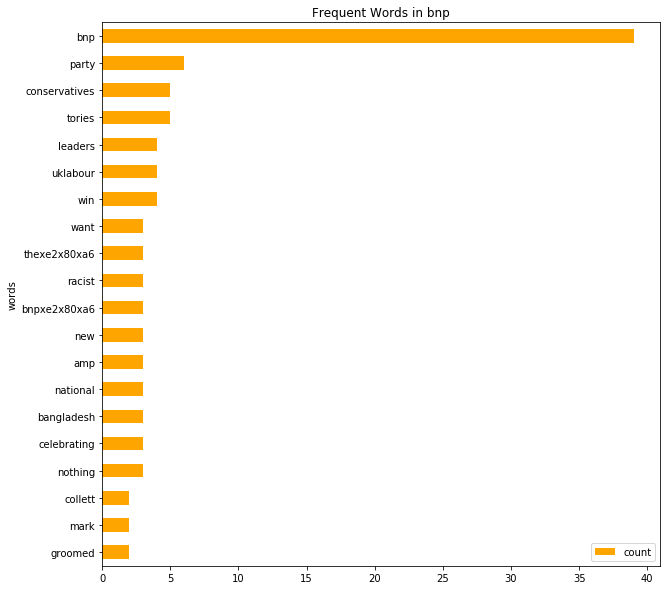

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
bnp_df.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="orange")

ax.set_title("Frequent Words in bnp")
plt.show()

Sentiments Analysis

In [28]:
#Creating textblob objects of the tweets 

In [29]:
sentiment_hsbc = [tb(tweet) for tweet in all_twt_hsbc_no_url]
sentiment_allianz = [tb(tweet) for tweet in all_twt_allianz_no_url]
sentiment_bnp = [tb(tweet) for tweet in all_twt_bnp_no_url]


In [30]:
sentiment_values_hsbc = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_hsbc]
sentiment_values_allianz = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_allianz]
sentiment_values_bnp = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_bnp]


In [31]:
sentiment_df_hsbc = pd.DataFrame(sentiment_values_hsbc, columns=["polarity", "tweet"])
sentiment_df_allianz = pd.DataFrame(sentiment_values_allianz, columns=["polarity", "tweet"])
sentiment_df_bnp = pd.DataFrame(sentiment_values_bnp, columns=["polarity", "tweet"])



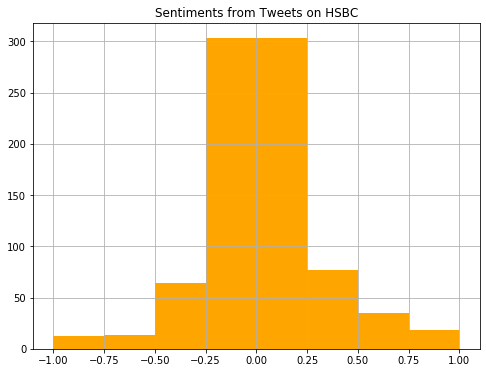

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_df_hsbc[sentiment_df_hsbc.polarity != 0].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],ax=ax,color="orange")
plt.title("Sentiments from Tweets on HSBC")
plt.show()

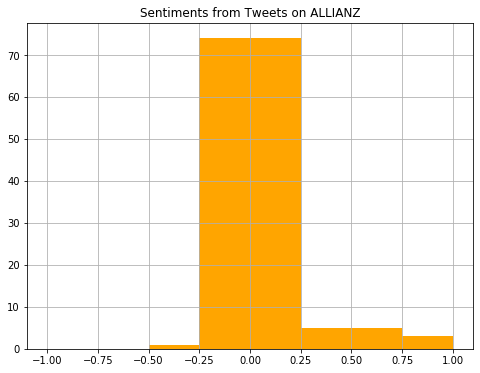

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_df_allianz[sentiment_df_allianz.polarity != 0].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],ax=ax,color="orange")
plt.title("Sentiments from Tweets on ALLIANZ")
plt.show()

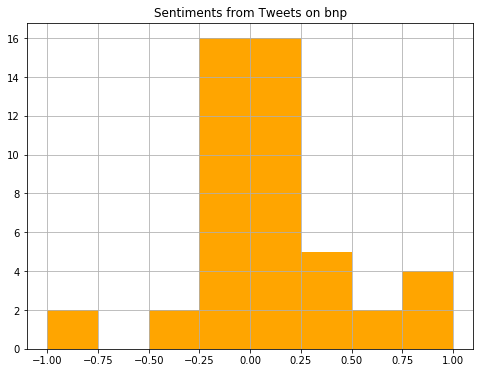

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_df_bnp[sentiment_df_bnp.polarity != 0].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],ax=ax,color="orange")
plt.title("Sentiments from Tweets on bnp")
plt.show()

In [35]:
#Creating the Word Cloud

In [36]:
mask = np.array(Image.open('twitter-logo.jpg'))

In [37]:
word_cloud_hsbc = WordCloud(background_color="white", max_words=2000, mask=mask)
hsbc_stringified = ','.join(hsbc_clean)
word_cloud_hsbc.generate(hsbc_stringified)

word_cloud_allianz = WordCloud(background_color="white", max_words=2000, mask=mask)
allianz_stringified = ','.join(allianz_clean)
word_cloud_allianz.generate(allianz_stringified)

word_cloud_bnp = WordCloud(background_color="white", max_words=2000, mask=mask)
bnp_stringified = ','.join(bnp_clean)
word_cloud_bnp.generate(bnp_stringified)

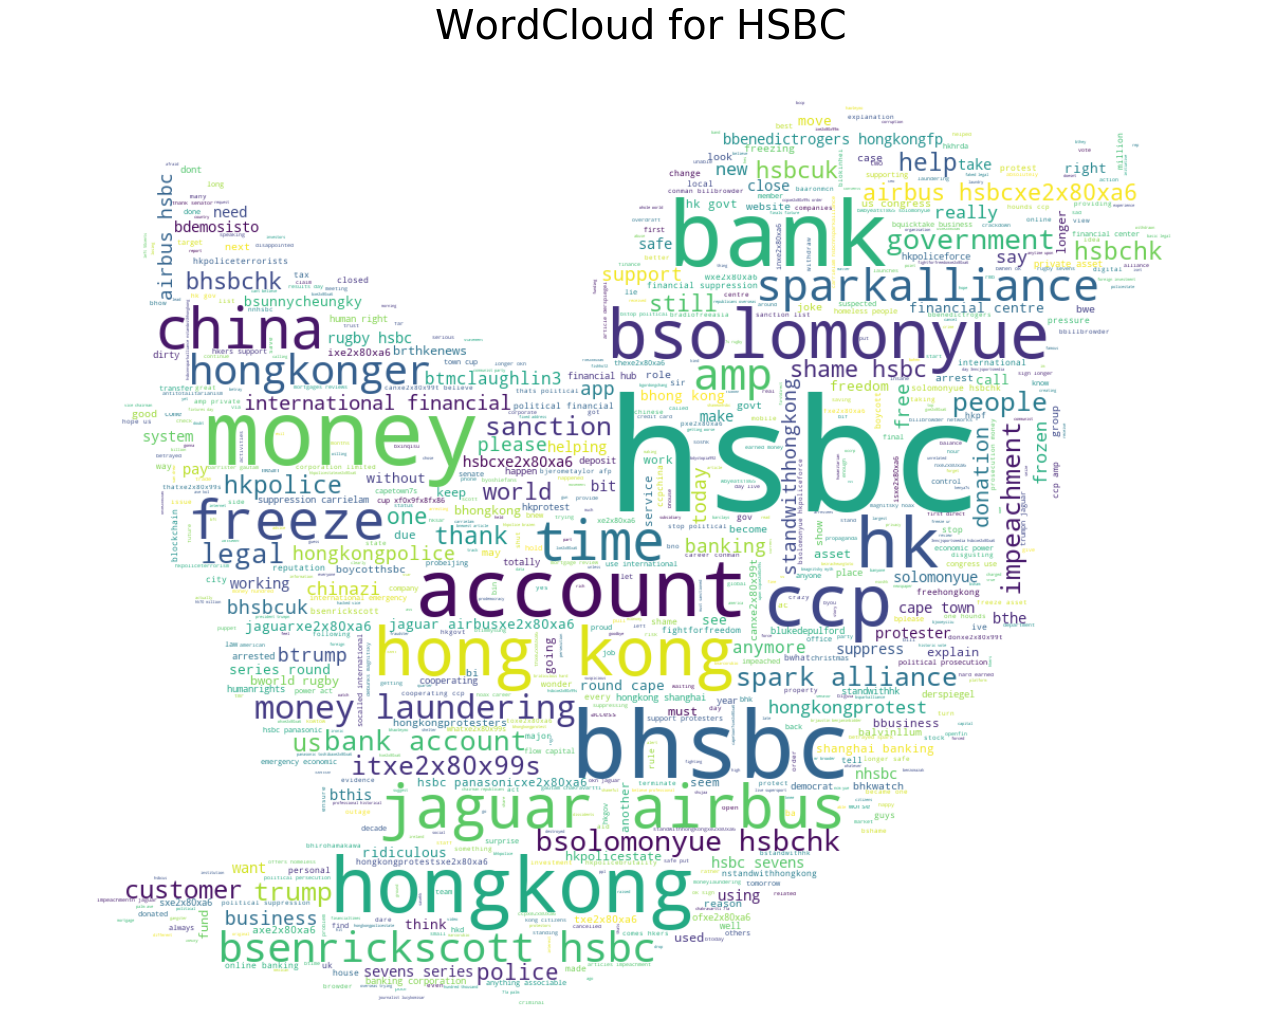

In [38]:
f = plt.figure(figsize=(50,50))
f.add_subplot(1,2, 2)
plt.imshow(word_cloud_hsbc, interpolation='bilinear')
plt.title('WordCloud for HSBC', size=40)
plt.axis("off")
plt.show()

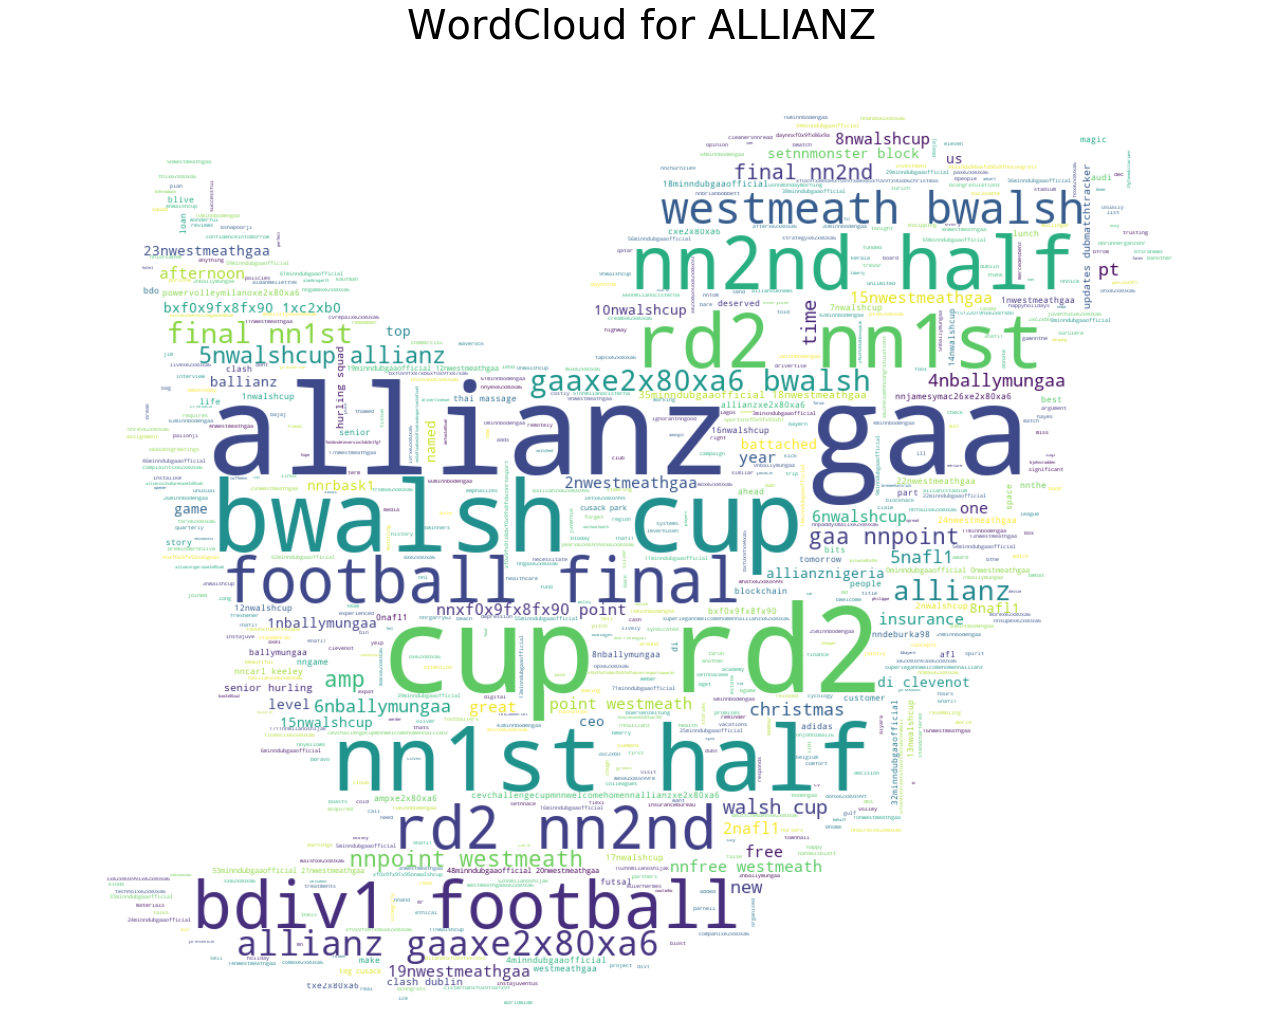

In [39]:
f = plt.figure(figsize=(50,50))
f.add_subplot(1,2, 2)
plt.imshow(word_cloud_allianz, interpolation='bilinear')
plt.title('WordCloud for ALLIANZ', size=40)
plt.axis("off")
plt.show()

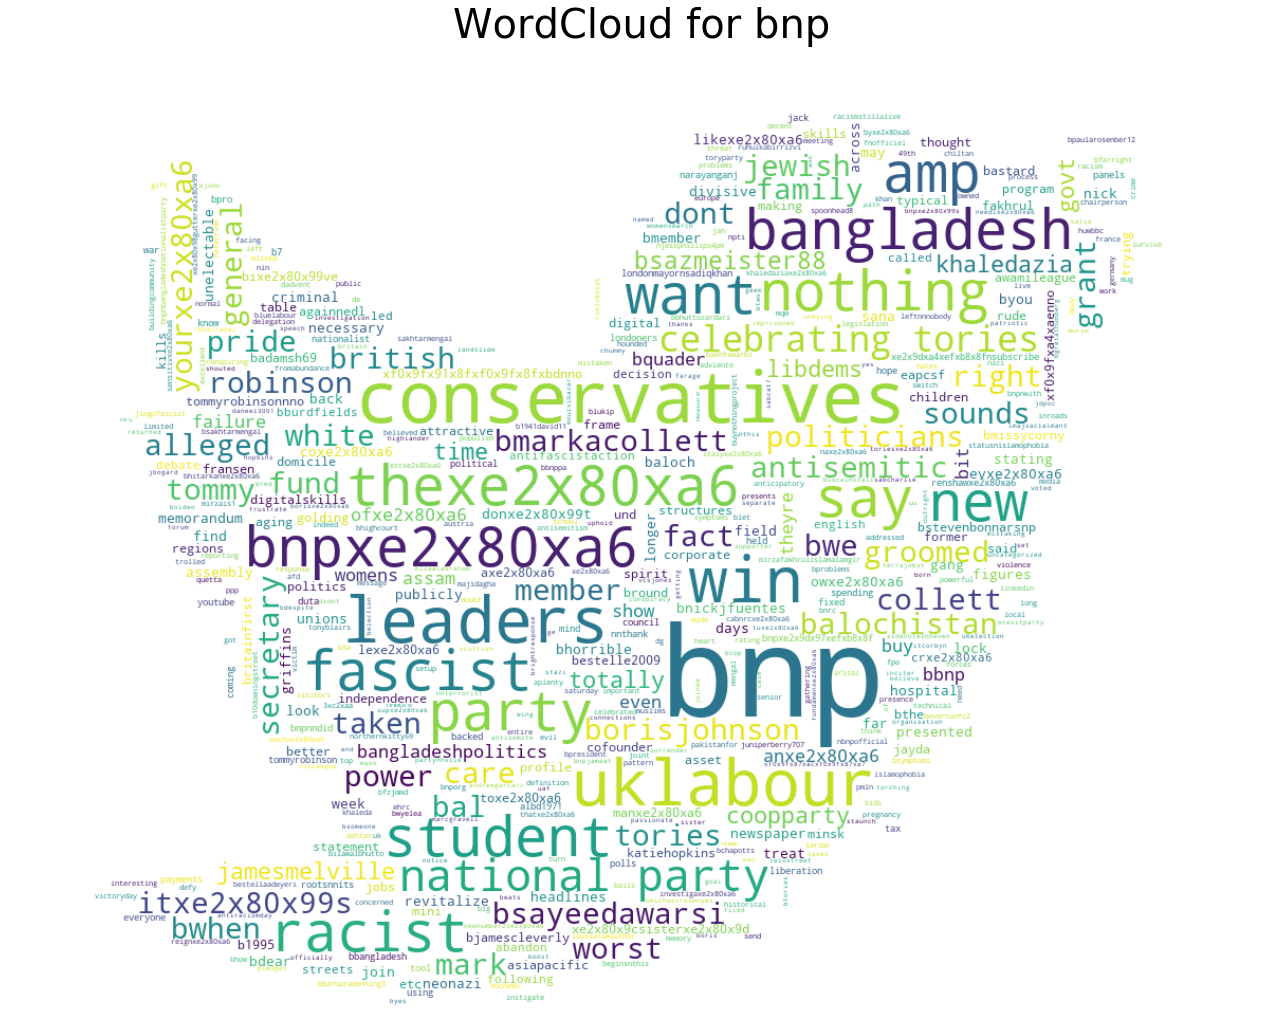

In [40]:
f = plt.figure(figsize=(50,50))
f.add_subplot(1,2, 2)
plt.imshow(word_cloud_bnp, interpolation='bilinear')
plt.title('WordCloud for bnp', size=40)
plt.axis("off")
plt.show()